# Sextortion Investigation Demo

In this demo we will investigate Bitcoin addresses that received money from Sextortion Spam victims. The data from this demo is taken from our study [Spams meet Cryptocurrencies: Sextortion in the Bitcoin Ecosystem](https://arxiv.org/abs/1908.01051) and is a subset of [all the 12,533 Bitcoin addresses](https://github.com/MatteoRomiti/Sextortion_Spam_Bitcoin) we have collected from 4,340,736 sextortion spam emails.

The data for this demo is available in `./examples/data/sextortion_addresses.json`

We are going to answer the following questions:

* Q1: How many USD did the input addresses receive in total?

* Q2: How many USD did the corresponding entities receive in total?

* Q3: How many addresses are controlled by these entities?

* Q4: Where did the money come from, where did it go to?

* Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

## Preparations

First, we install the graphsense-python package as described in the [README](https://github.com/graphsense/graphsense-python/blob/develop/README.md) of this repository. Import the package and configure the API endpoint. An API key for the public GraphSense demo API can be requested by sending an email to contact@graphense.info.

In [1]:
import graphsense
from graphsense.api import addresses_api, blocks_api, entities_api, general_api

import json

from pprint import pprint

In [2]:
configuration = graphsense.Configuration(
    #host = "https://api.graphsense.info/",
    host = "http://spark-master:9001",
    api_key = {'api_key': 'REPLACE_WITH_API_KEY'})

CURRENCY = 'btc'

We can test whether or client works, by checking what data the GraphSense endpoint provides

In [3]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = general_api.GeneralApi(api_client)
    api_response = api_instance.get_statistics()
    pprint(api_response)

{'currencies': [{'data_sources': [{'id': 'btc_ledger',
                                   'report_uuid': 'btc_ledger',
                                   'version': {'nr': '683014',
                                               'timestamp': '2021-05-10 '
                                                            '23:50:21'},
                                   'visible_name': 'BTC Blockchain'}],
                 'name': 'btc',
                 'no_address_relations': 5367863690,
                 'no_addresses': 827527043,
                 'no_blocks': 683014,
                 'no_entities': 394318887,
                 'no_labels': 510,
                 'no_txs': 641154581,
                 'notes': [],
                 'timestamp': 1620690621,
                 'tools': []},
                {'data_sources': [{'id': 'bch_ledger',
                                   'report_uuid': 'bch_ledger',
                                   'version': {'nr': '687204',
                                

Now we load the provided sample Bitcoin addresses


In [4]:
INPUT_FILE = './data/sextortion_addresses.json' # 245 sextortion addresses
with open(INPUT_FILE, 'r') as fp:
    input_addresses = json.load(fp)
    
pprint(f"Example address: {input_addresses[0]}")
print(f"Total number of addresses: {len(input_addresses)}")

'Example address: 1JwRp2J8bQcoG8XTUbxQZaEj9QB4RB6zEa'
Total number of addresses: 245


# Q1. How many USD (US dollars) did the input addresses receive in total?

GraphSenes supports several asset types: Bitcoin (BTC), Bitcoin Cash (BCH), Litecoin (LTC), ZCash (ZEC).

We are investigating Bitcoin transactions, therefore we set the default currency to Bitcoin **BTC**.

In [5]:
address_details = {}

In [6]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = addresses_api.AddressesApi(api_client)
    try:
        # Retrieve all addresses in batch
        addresses = api_instance.list_addresses(CURRENCY, ids=input_addresses)
        for a in addresses.addresses:
            address_details[a.address] = a
    except graphsense.ApiException as e:
        print("Exception when calling AddressesApi: %s\n" % e)

In [7]:
total_received = sum([el.total_received.usd for el in address_details.values()])
print("{} addresses received {:,.2f} USD".format(len(address_details), total_received))

245 addresses received 882,341.53 USD


# Q2: How many USD did the corresponding entities receive in total?
# Q3: How many addresses are controlled by these entities?

For each address, fetch the corresponding entity and store it in a dict for further use

In [8]:
address_entity = dict()  # address, entity_id
entities = dict()  # entity_id, details (for later)

In [9]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = addresses_api.AddressesApi(api_client)
    for i, a in enumerate(input_addresses):
        print(i + 1, end='\r')
        e = api_instance.get_address_entity(CURRENCY, a)
        address_entity[a] = e.entity
        entities[e.entity] = e

For each entity, fetch all addresses controlled by that entity

In [10]:
entity_addresses = dict()  # entity_id, list of addresses with details

with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    for i, e in enumerate(address_entity.values()):
        print(i + 1, end='\r')
        if e not in entity_addresses:
            entity_addresses[e] = api_instance.list_entity_addresses(CURRENCY, e)


Count the number of retrieved entities, the number of addresses controlled by these entities, and sum up the total number of USD received by these entities

In [11]:
n_addresses = 0
usd_in = 0
for v in entities:
    n_addresses += entities[v].no_addresses
    usd_in += entities[v].total_received.usd

print("{} entities with {:,.0f} addresses received {:,.0f} USD".format(len(entities), n_addresses, usd_in))

102 entities with 1,850,881 addresses received 10,742,255,577 USD


Investigate these entities by plotting a histogram.

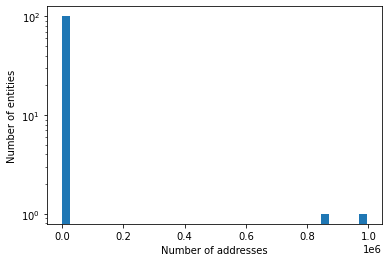

In [12]:
import matplotlib.pyplot as plt

#no_addresses_in_entities = [e for e in entities]
#no_addresses_in_entities

no_entity_addresses = [entity.no_addresses for entity in entities.values()]
plt.hist(no_entity_addresses, bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of addresses')
plt.yscale('log')
plt.show()

We can assume that entities with very large number of addresses are services (e.g., exchanges) or super-clusters. Therefore, for our further analysis, we filter our entities by **ignoring entities with more than 10K address**.

In [13]:
filtered_entities = [entity for entity in entities.values() if entity.no_addresses < 10000]
len(filtered_entities)

n_addresses = 0
usd_in = 0
for entity in filtered_entities:
    n_addresses += entity.no_addresses
    usd_in += entity.total_received.usd
    
print("{} entities with {:,.0f} addresses received {:,.0f} USD"
      .format(len(filtered_entities), n_addresses, usd_in))

100 entities with 514 addresses received 1,387,993 USD


# Q4: Where did the money come from, where did it go to?

For all filtered entities we now gather all incoming and outgoing entities.

In [14]:
entity_nbrs_in = dict()
entity_nbrs_out = dict()

with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    for i, e in enumerate(filtered_entities):
        print(i+1, end='\r')
        if e.entity not in entity_nbrs_in:
            entity_nbrs_in[e.entity] = api_instance.list_entity_neighbors(CURRENCY, e.entity, 'in')
        if e.entity not in entity_nbrs_out:
            entity_nbrs_out[e.entity] = api_instance.list_entity_neighbors(CURRENCY, e.entity, 'out')

TypeError: __init__() missing 1 required positional argument: 'has_labels'

To get an overview, we count the number of incoming and outgoing entities

In [ ]:
no_incoming_entities = {key:len(entity_nbrs_in[key].neighbors) for key in entity_nbrs_in}

no_outgoing_entities = {key:len(entity_nbrs_out[key].neighbors) for key in entity_nbrs_out}

In [ ]:
plt.hist(no_incoming_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

In [ ]:
plt.hist(no_outgoing_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

## Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

In [ ]:
entity_labels = {}

# Collect IDs of those incoming entities that carry labels
known_incoming_entities = []

for neighbors in entity_nbrs_in.values():
    for neighbor in neighbors.neighbors:
        if neighbor.has_labels:
            known_incoming_entities.append(int(neighbor.id))
            
# Now collect tags for these entities
with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    try:
        for e in set(known_incoming_entities):
            tags = api_instance.list_tags_by_entity(CURRENCY, e)
            for tag in tags['entity_tags']:
                pprint(tag.label)
                entity_labels[e] = tag.label
    except graphsense.ApiException as e:
        print("Exception when calling EntitiesApi: %s\n" % e)

In [ ]:
# Collect IDs of those outoging entities that carry labels
known_outgoing_entities = []

for neighbors in entity_nbrs_out.values():
    for neighbor in neighbors.neighbors:
        if neighbor.has_labels:
            known_outgoing_entities.append(int(neighbor.id))

# Now collect tags for these entities
with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    try:
        for e in set(known_outgoing_entities):
            tags = api_instance.list_tags_by_entity(CURRENCY, e)
            for tag in tags['entity_tags']:
                pprint(tag.label)
                entity_labels[e] = tag.label
    except graphsense.ApiException as e:
        print("Exception when calling EntitiesApi: %s\n" % e)

## Network Visualization

Finally, we build and visualize a network showing the entities we just identified and collected.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

### Entities sending money to sextortion addresses

In [ ]:
g = nx.DiGraph()
for (entity, neighbors) in entity_nbrs_in.items():
    for neighbor in neighbors.neighbors:
        if neighbor.has_labels:
            g.add_edge(neighbor['id'], entity)
            g.add_node(entity, label='sextortion')
            if int(neighbor['id']) in entity_labels:
                g.add_node(neighbor['id'], label=entity_labels[int(neighbor['id'])])
            else:
                g.add_node(neighbor['id'], label='Unknown')                

In [ ]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

In [ ]:
node_colours = []

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')

In [ ]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sexytortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        pos=pos)


### Entities receiving money from sextortion addresses

In [ ]:
g = nx.DiGraph()
for (entity, neighbors) in entity_nbrs_out.items():
    for neighbor in neighbors.neighbors:
        if neighbor.has_labels:
            g.add_edge(entity, neighbor['id'])
            g.add_node(entity, label='sextortion')
            if int(neighbor['id']) in entity_labels:
                g.add_node(neighbor['id'], label=entity_labels[int(neighbor['id'])])
            else:
                g.add_node(neighbor['id'], label='Unknown')                

In [ ]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

In [ ]:
node_colours = []
label_dict = {}

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')
        label_dict[node_id] = node_id

In [ ]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sexytortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        labels=label_dict,
        with_labels=True,
        pos=pos)
